## Agenda

<ol>
  <li>Introduction</li>
  <li>Grid Search</li>
  <li>Random Search</li>
  <li>Genetic Algorithm</li>
</ol> 

## Introduction

### Recap: Parameter vs Hyperparameters

### Parameters vs Hyperparameters

| **Aspect** | **Model Parameters** | **Hyperparameters** |
|------------|----------------------|----------------------|
| **Definition** | Values the algorithm learns from data during training. | Values set before training to steer the learning process. |
| **Update** | Updated via optimisation routines (e.g., back-propagation, least squares). | Remain fixed during a single fit; tuned by search procedures. |
| **Examples** | • Weights and biases in neural nets  <br> • Coefficients β in regression  <br> • Tree split thresholds | • Learning rate, epochs, batch size  <br> • Regularisation parameter λ (L1/L2 penalty)  <br> • No. of trees, max depth  <br> • Kernel type (Linear, Polynomial, RBF) in SVM |
| **Scale** | Order of magnitude: 10⁴–10⁸ variables (deep nets) → very large. | Usually 1–100 knobs, but search space can explode combinatorially. |


### Grid Search

Grid search systematically tries all possible combinations of hyperparameters in a predefined search space.
- Exhaustive but computationally expensive.
- Guarantees the best result within the given grid.

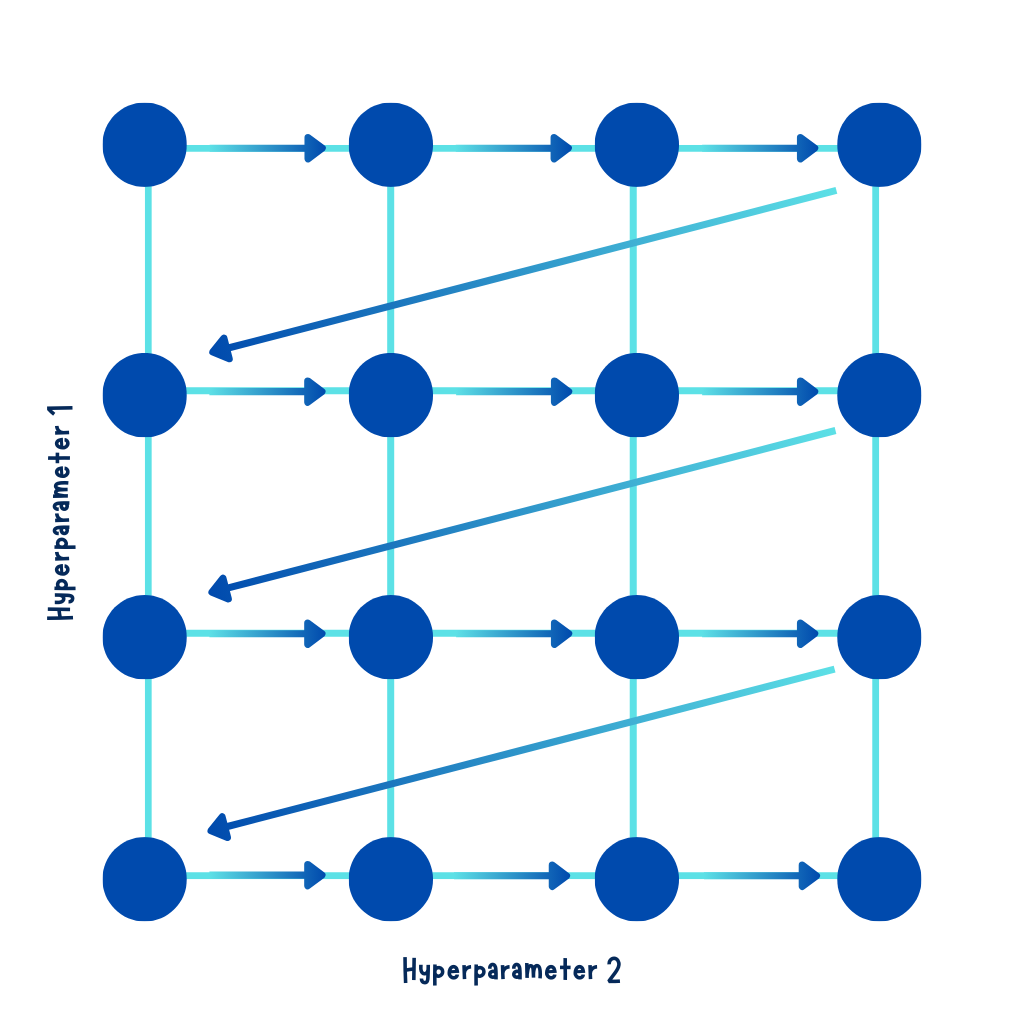

### Random Search
Random search samples random combinations of hyperparameters from the search space.
- More efficient than grid search when only a few hyperparameters matter.
- Does not guarantee best solution, but often finds good ones quickly.

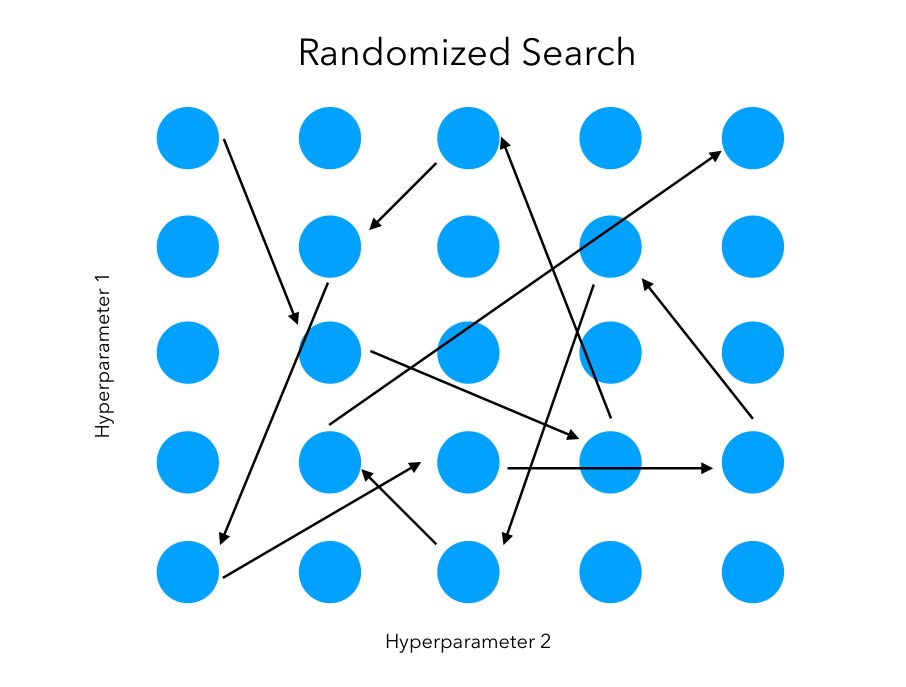


### Genetic Algorithm
Genetic algorithms use evolutionary principles (selection, crossover, mutation) to evolve better hyperparameter sets over generations.
- Balances exploration and exploitation.
- Can discover strong configurations without evaluating the full search space.
- More complex to implement.

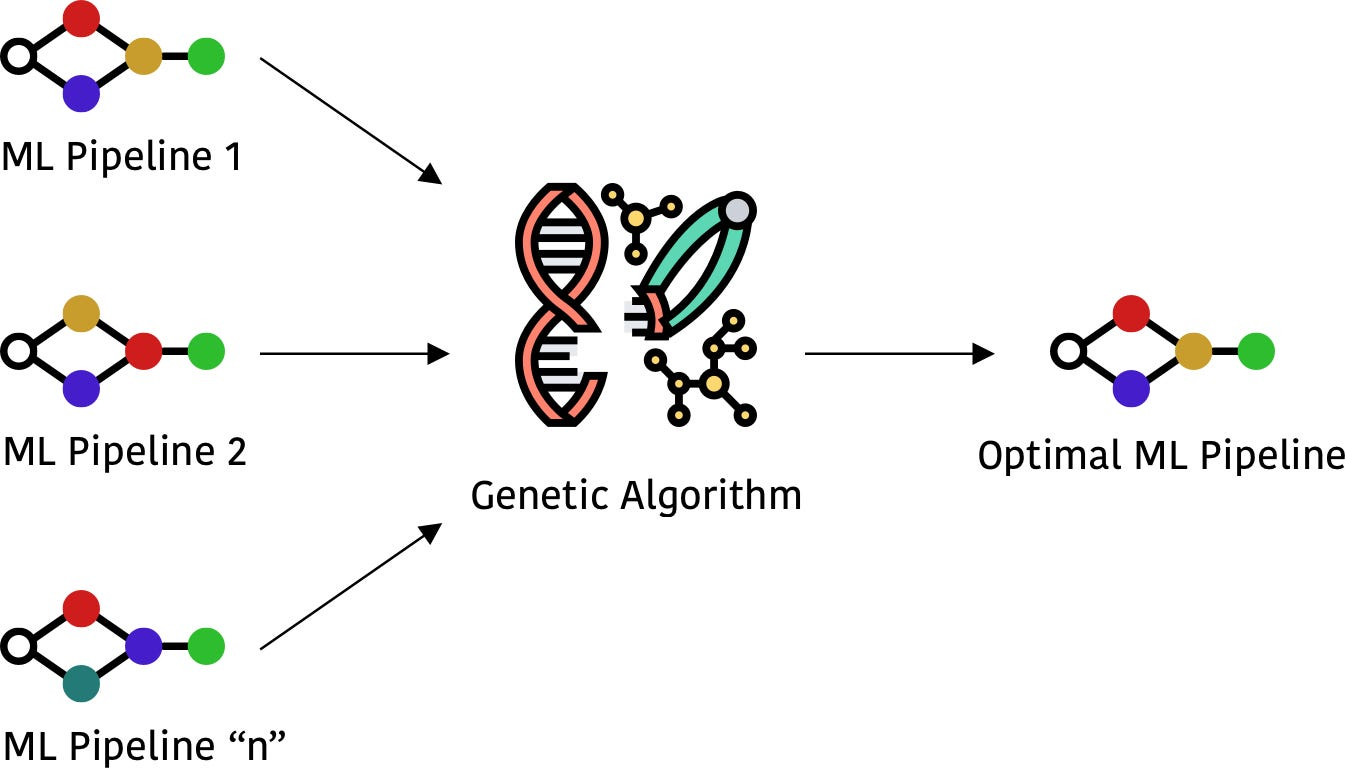

## Practice

In this session, we’ll use a decision tree as our example machine learning model. We’ll apply different hyperparameter optimization (HPO) strategies and compare their performance.

### Setup

In this session, we'll try to implement everything as manually as possible so we can understand the underlying mechanisms.
We use **pandas** and **numpy** for data handling, ML model and utilities from **scikit-learn (sklearn)**, **matplotlib** for basic visualization. 

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools
import random
# Import decision tree regressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error

### Data preparation

#### Data sources
This session, we'll use `emajogi_watertemp` dataset. The dataset contains information about the river water temperature of the Emajogi river and the air temperature in Tartu from 2019 to 2024.We'll use month,day of month and air temperature to predict water temperature.

- Water tempearture: https://www.ilmateenistus.ee/siseveed/ajaloolised-vaatlusandmed/
- Tartu air tempeature. https://open-meteo.com/en/docs/historical-weather-api#latitude=58.3806&longitude=26.7251&start_date=2019-01-01&hourly=&daily=temperature_2m_max&timezone=GMT



In [138]:
df_emajogi = pd.read_csv('emajogi_watertemp.csv')
df_emajogi['Date'] = pd.to_datetime(df_emajogi['Date'], format='%m/%d/%Y')
df_emajogi

,Date,Water_temp,Tartu_max_daily_temp
0,2019-01-01,0,3.0
1,2019-01-02,0,1.6
2,2019-01-03,0,-3.5
3,2019-01-04,0,-2.5
4,2019-01-05,0,-4.0
...,...,...,...
2088,2024-09-19,19,18.6
2089,2024-09-20,18,18.3
2090,2024-09-21,18,18.7
2091,2024-09-22,17,13.2


#### Visualize target and main feature

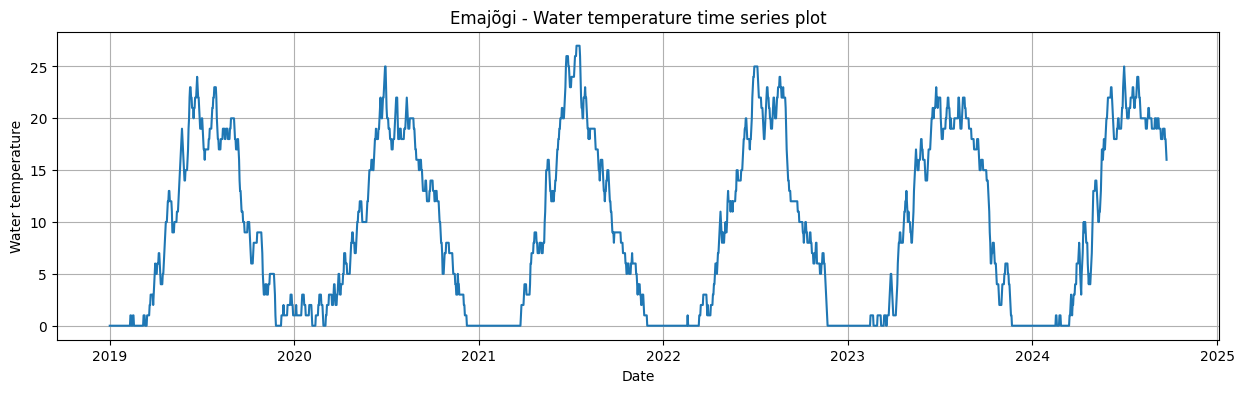

In [139]:
plt.figure(figsize=(15, 4))

## Plot line plot using matplotlib
plt.plot(df_emajogi['Date'], df_emajogi['Water_temp'])


## Add title
plt.title('Emajõgi - Water temperature time series plot')

## Add x and y labels
plt.xlabel('Date')
plt.ylabel('Water temperature')
plt.grid(True)
plt.show()



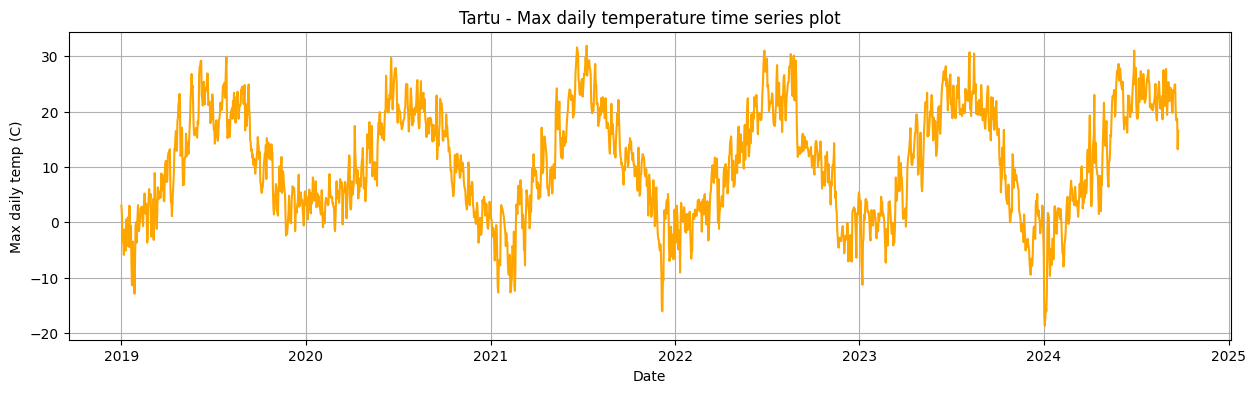

In [140]:
plt.figure(figsize=(15, 4))

## Plot line plot using matplotlib
plt.plot(df_emajogi['Date'], df_emajogi['Tartu_max_daily_temp'], color='orange')

## Add title
plt.title('Tartu - Max daily temperature time series plot')

## Add x and y labels
plt.xlabel('Date')
plt.ylabel('Max daily temp (C)')
plt.grid(True)
plt.show()


#### Split into train and test

HPO only focus on tuning **hyperparameters**; there is no module to handle data cleaning or preprocessing.  
Therefore, we first prepare the dataset for ML model ourselves. We separate the `month` and `day` of month into individual columns. This ensures the model has clean and well-structured input features.  

Next, we split the dataset into **training**, **validation**, and **test** sets. The training set is used to fit the machine learning model, the validation set is used during the Bayesian Optimization process to evaluate candidate hyperparameters, and the test set is kept aside for the final unbiased evaluation.  

In this session, we simplify the split by dividing data according to years. However, in real-world applications, data splitting must be performed much more carefully (e.g, using stratified sampling or domain-specific strategies) to avoid bias and ensure proper generalization.

In [141]:
df_emajogi['month'] = df_emajogi['Date'].dt.month
df_emajogi['day'] = df_emajogi['Date'].dt.day


## Note - I chose one train/valid/test split, based on years. But could be different based on the use case.
train = df_emajogi[df_emajogi['Date'].dt.year <= 2021].copy()
valid = df_emajogi[df_emajogi['Date'].dt.year == 2022].copy()
test = df_emajogi[df_emajogi['Date'].dt.year >= 2023].copy()

print('Train_len:', len(train), '\nValid_len:', len(valid), '\nTest_len:', len(test))

features = ['Tartu_max_daily_temp','month', 'day']
target = 'Water_temp'


## Split trian into X and y
X_train = train[features]
y_train = train[target]

X_valid = valid[features]
y_valid = valid[target]

X_test = test[features]
y_test = test[target]

train.head(5)

Train_len: 1096 
Valid_len: 365 
Test_len: 632


,Date,Water_temp,Tartu_max_daily_temp,month,day
0,2019-01-01,0,3.0,1,1
1,2019-01-02,0,1.6,1,2
2,2019-01-03,0,-3.5,1,3
3,2019-01-04,0,-2.5,1,4
4,2019-01-05,0,-4.0,1,5


In addition, we'll concatenate the training and validation sets. This combined split will be used to train the models before making final predictions on the test set.

In [142]:
## Append X_train and X_val
train_valid = pd.concat([train,valid])
X_train_valid = pd.concat([X_train, X_valid])
y_train_valid = pd.concat([y_train, y_valid])

### Dictionary to store all results

In [143]:
loss_dict = {}

### Baselines 

#### Decision tree with default hyperparameters

As our first baseline, we’ll try the default configuration of the decision tree. Since no loop or inner-loop training is required, we’ll use the `train_valid` set for training and the `test` set for the final evaluation.

In [144]:
dt = DecisionTreeRegressor()
dt.fit(X_train_valid, y_train_valid)

## Predict
test['Water_temp_pred'] = dt.predict(X_test)
print(test.head(5))
loss_dict['Default']=mean_absolute_error(test['Water_temp_pred'],y_test)
print(f"Test loss with default hyperparameters {loss_dict['Default']}")

           Date  Water_temp  Tartu_max_daily_temp  month  day  Water_temp_pred
1461 2023-01-01           0                   4.9      1    1              1.0
1462 2023-01-02           0                  -0.1      1    2              0.0
1463 2023-01-03           0                   3.9      1    3              1.0
1464 2023-01-04           0                   0.4      1    4              0.0
1465 2023-01-05           0                  -6.9      1    5              0.0
Test loss with default hyperparameters 1.9208860759493671


#### Manual configurations
Another baseline we’ll use is manual configuration. We’ll try two different manual configurations.

The helper method below trains a decision tree model and returns the trained model, the loss on the test set, and the predictions (which we’ll later use for visualization).

In [145]:
def manual_config(X_train,y_train,X_test,y_test,max_depth):
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(X_train, y_train)

    results = dt.predict(X_test)
    loss = mean_absolute_error(results,y_test)
    return model,loss,results


The helper method below takes the trained decision tree model and creates a tree visualization. <br>
For more details on `plot_tree` method, see the scikit-learn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).

In [146]:
from sklearn.tree import plot_tree

def visualise_model(model):
    plt.figure(figsize=(14, 6))
    plot_tree(model, feature_names=['Tartu_max_daily_temp','month', 'day'], filled=True, fontsize=10, impurity=False,max_depth=4)
    plt.show()


The following helper function takes a data split (with features and ground truth) along with the predictions and visualizes them.

In [147]:
def visualise_results(data_split,prediction):
    plt.figure(figsize=(10, 6))
    # Plot the true water temperature
    plt.plot(data_split['Date'], data_split['Water_temp'], label='True', color='blue')

    # Plot the predicted water temperature
    plt.plot(data_split['Date'], prediction, label='Prediction', color='orange')

    # Add title
    plt.title(f'Emajõgi Water temperature prediction')

    # Add labels
    plt.xlabel('Date')
    plt.ylabel('Water Temperature')

    # Add a legend to differentiate between True and Prediction
    plt.legend()

    # Add a grid
    plt.grid(True)

    # Show the plot
    plt.show()
    

In [148]:
model_m1,loss_m1,results_m1=manual_config(X_train_valid,y_train_valid,X_test,y_test,2)
model_m2,loss_m2,results_m2=manual_config(X_train_valid,y_train_valid,X_test,y_test,10)

loss_dict['Manual_1']=loss_m1
loss_dict['Manual_2']=loss_m2

================================================== First manual configuration with max depth 2 ==================================================


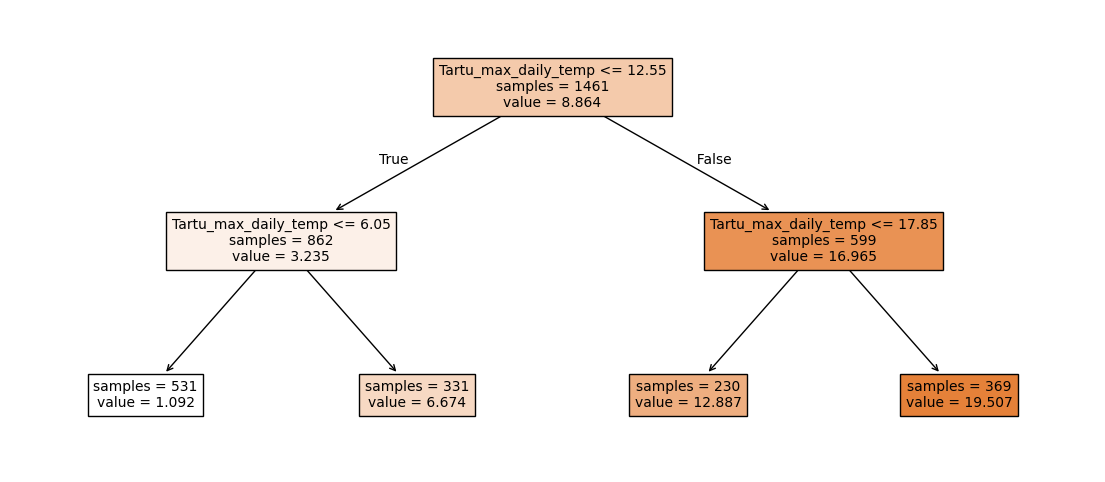

================================================== Second manual configuration with max depth 10 ==================================================


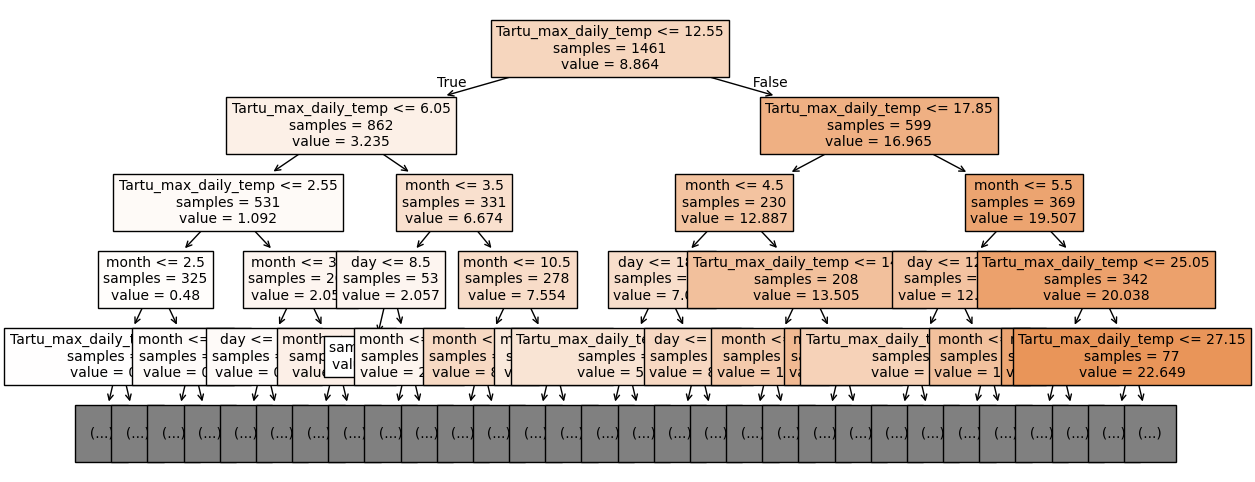

In [149]:
print(50*'=','First manual configuration with max depth 2',50*'=')
visualise_model(model_m1)
print(50*'=','Second manual configuration with max depth 10',50*'=')
visualise_model(model_m2)

================================================== First manual configuration with max depth 2 ==================================================


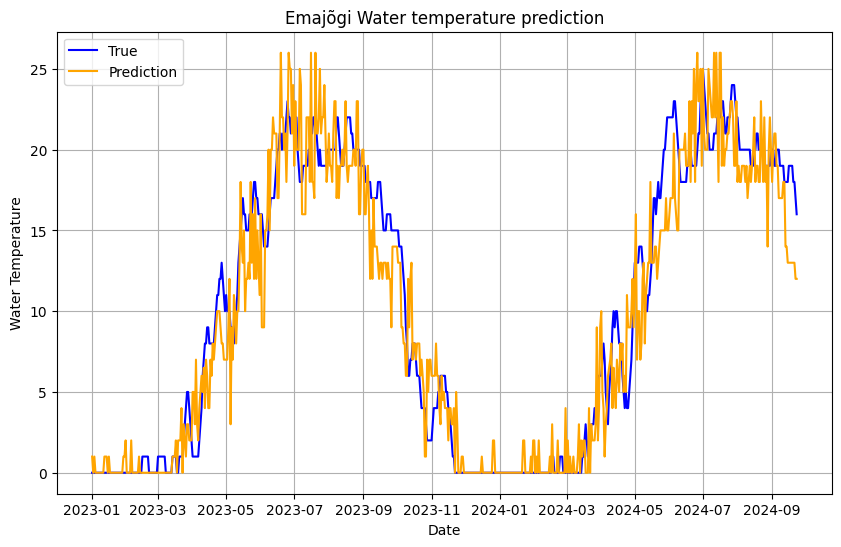

================================================== Second manual configuration with max depth 10 ==================================================


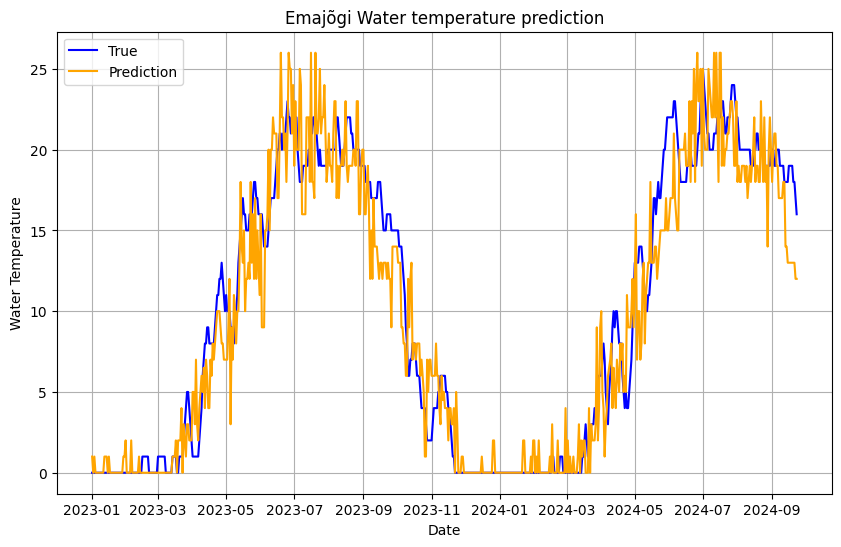

In [150]:
print(50*'=','First manual configuration with max depth 2',50*'=')
visualise_results(test,results_m1)
print(50*'=','Second manual configuration with max depth 10',50*'=')
visualise_results(test,results_m2)

### Manual Hyperparameter Exploration (for intuition)

Before starting grid search, we’ll do a quick exploratory analysis of key hyperparameters. This helps us better understand how the loss surface of a decision tree can change depending on hyperparameter choices.

#### Effects of max depths

First, we’ll vary max_depth and observe its effect.

In [151]:
#### Create loop to fit model for different max_depth values and calculate the MAE

max_depth_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
mae_list = []

for max_depth in max_depth_list:
  dt = DecisionTreeRegressor(max_depth=max_depth)
  dt.fit(X_train, y_train)
  valid['Water_temp_pred'] = dt.predict(X_valid)
  mae = mean_absolute_error(valid['Water_temp'], valid['Water_temp_pred'])
  mae_list.append(mae)


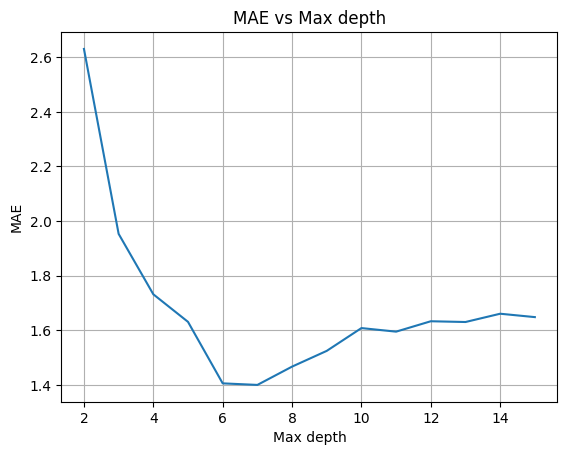

In [152]:
plt.plot(max_depth_list, mae_list)
plt.xlabel('Max depth')
plt.ylabel('MAE')
plt.title('MAE vs Max depth')
plt.grid(True)
plt.show()

We can see that max_depth has a strong impact on the performance of the decision tree.

#### Evaluate performance based on min size split
Next, let’s look at min_samples_split. As before, we’ll try different values, but this time across multiple max_depth settings.

The helper function below takes a single max_depth value and an array of min_samples_split values. It evaluates all combinations, stores the results, and then visualizes them.

In [153]:
def min_sample_splits_for_each_max_depth(max_depth,min_sample_splits):
  mae_list = []

  for min_sample_split in min_sample_splits:
    dt = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_sample_split)
    dt.fit(X_train, y_train)
    valid['Water_temp_pred'] = dt.predict(X_valid)
    mae = mean_absolute_error(valid['Water_temp'], valid['Water_temp_pred'])
    mae_list.append(mae)


  ### Plot the MAE values based on min_samples_split using matplotlib

  plt.plot(min_sample_splits, mae_list, marker='o')
      
  # Add title
  plt.title(f'MAE based on Min Samples Split| Max Depth = {max_depth}')
      
      ### Plot between where min_samples_split more then 5
  plt.plot(min_sample_splits, mae_list, marker='o')

  plt.grid(True)

  plt.show()



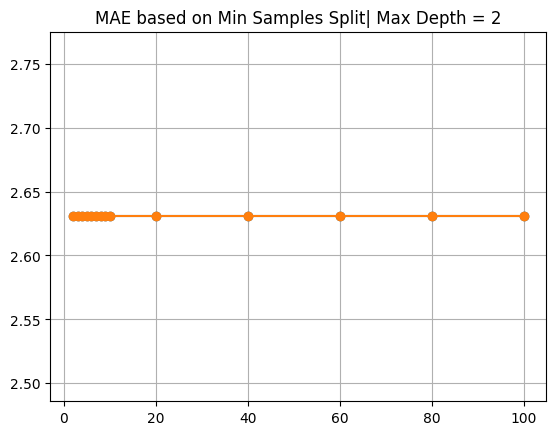

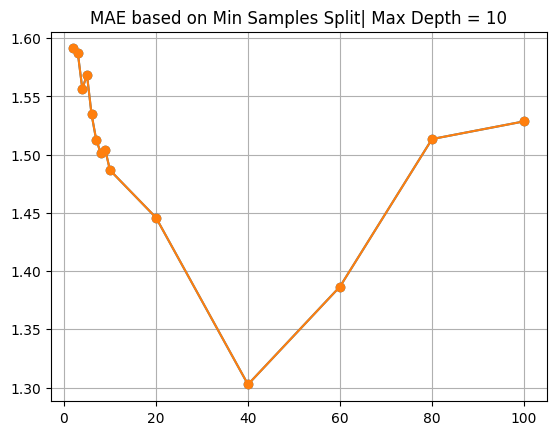

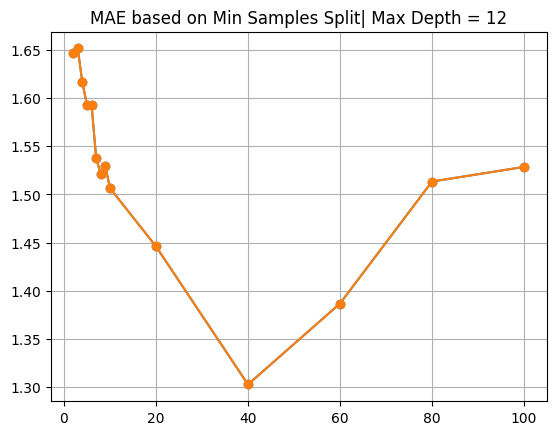

In [154]:
min_sample_splits = [2,3,4,5,6,7,8,9,10,20,40,60,80,100]

min_sample_splits_for_each_max_depth(max_depth=2,min_sample_splits=min_sample_splits)
min_sample_splits_for_each_max_depth(max_depth=10,min_sample_splits=min_sample_splits)
min_sample_splits_for_each_max_depth(max_depth=12,min_sample_splits=min_sample_splits)



From these results, it’s clear that the effect of min_samples_split depends on the depth of the tree. For shallow trees, the split size barely matters, while for deeper trees it becomes much more influential.

The results from this analysis illustrates why efficient hyperparameter optimization (HPO) algorithms are important. The significance of a hyperparameter can change depending on the values of others, and performance does not always improve monotonically (e.g., increasing max_depth beyond a certain point can actually make results worse). Grid search helps us systematically explore these interactions.

### Grid search 

In this section, we’ll implement grid search using plain Python loops.

#### Creating search space

First, we’ll define the search space by specifying possible values for max_depth and min_samples_split. Then, we’ll use itertools (a standard Python library) to generate all possible combinations of these values.

In [155]:
### Generate search space of max_depth and min_sample_leaf
max_depths = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
min_samples_leafs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40, 60, 80, 100]

print('Number of Max depths:', len(max_depths))
print('Number of Min sample leafs:', len(min_samples_leafs))

search_space = list(itertools.product(max_depths, min_samples_leafs))
df_eval = pd.DataFrame(search_space, columns=['max_depth', 'min_samples_leaf'])

print("Total number of configurations: ", df_eval.shape[0])

df_eval['MAE'] = '' #Empty Column for Storing Loss Later on

df_eval

Number of Max depths: 10
Number of Min sample leafs: 15
Total number of configurations:  150


,max_depth,min_samples_leaf,MAE
0,2,1,
1,2,2,
2,2,3,
3,2,4,
4,2,5,
...,...,...,...
145,20,20,
146,20,40,
147,20,60,
148,20,80,


#### Evaluate all configuration

The code below performs the main step of grid search. For each configuration, we train a model on the training set and then evaluate it on the validation set.

In [156]:
#### Loop around the search space and calculate the MAE for each combination of max_depth and min_samples_leaf

for i, row in df_eval.iterrows():
  max_depth = row['max_depth']
  min_samples_leaf = row['min_samples_leaf']

  dt = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)

  dt.fit(X_train, y_train)
  valid['Water_temp_pred'] = dt.predict(X_valid)
  mae = mean_absolute_error(valid['Water_temp'], valid['Water_temp_pred'])
  df_eval.at[i, 'MAE'] = mae

#### Extracting best configuration from results

After performing the grid search, we will sort the DataFrame by loss value and select the hyperparameters from the first row

In [157]:
df_eval_sorted = df_eval.sort_values('MAE')
print(df_eval_sorted.head(3))

best_max_depth=df_eval_sorted.iloc[0]['max_depth']
best_min_sample=df_eval_sorted.iloc[0]['min_samples_leaf']
print(f'\nBest Config \nMax depth: {best_max_depth} \nMinj Sample Split {best_min_sample}')

    max_depth  min_samples_leaf       MAE
84          7                10  1.305371
81          7                 7  1.306112
80          7                 6  1.306837

Best Config 
Max depth: 7 
Minj Sample Split 10


To obtain the final result, we now train our model using the selected configuration on the train_valid set and then evaluate it on the test set.

In [158]:
dt = DecisionTreeRegressor(max_depth=best_max_depth, min_samples_leaf=best_min_sample)

dt.fit(X_train_valid,y_train_valid)
loss_dict['Grid Search']=mean_absolute_error(dt.predict(X_test),y_test)

### Random search

#### Define search space for random search

Unlike grid search, which iterates over all defined points in the search space, random search allows us to define a larger search space, giving a higher chance of selecting better configurations at random.

In [159]:
max_depth_list = np.arange(2, 21, 1)
min_samples_leaf_list = np.arange(1, 101, 1)

## From itertools create all possible combinations of max_depth and min_samples_leaf
search_space = list(itertools.product(max_depth_list, min_samples_leaf_list))
df_random_search_space = pd.DataFrame(search_space, columns=['max_depth', 'min_samples_leaf'])

print("Total total size of search space: ", df_random_search_space.shape[0])

df_random_search_space['MAE'] = '' #Empty Column for Storing Loss Later on

df_random_search_space


Total total size of search space:  1900


,max_depth,min_samples_leaf,MAE
0,2,1,
1,2,2,
2,2,3,
3,2,4,
4,2,5,
...,...,...,...
1895,20,96,
1896,20,97,
1897,20,98,
1898,20,99,


#### Preforming random sampling

After defining the search space, we randomly sample configurations from the entire space. For comparison, we sample the same 150 configurations, which matches the total number of points used in the grid search earlier.

Another difference is that the random seed affects results more in random search. This makes random variation more reproducible.

P.S. Feel free to experiment with the random seed when you try this notebook yourself.
You never know, you might get an unexpectedly great result by pure chance :)

In [160]:
config_size = 150
np.random.seed(42)
df_random_search=df_random_search_space.sample(config_size)


for i, row in df_random_search.iterrows():
  dt = DecisionTreeRegressor(max_depth=row['max_depth'], min_samples_leaf=row['min_samples_leaf'])
  dt.fit(X_train, y_train)
  valid['Water_temp_pred'] = dt.predict(X_valid)
  mae = mean_absolute_error(valid['Water_temp'], valid['Water_temp_pred'])
  df_random_search.at[i, 'MAE'] = mae


print("Sampled configs: ")
df_random_search

Sampled configs: 


,max_depth,min_samples_leaf,MAE
1222,14,23,1.379087
111,3,12,1.952934
554,7,55,1.65846
526,7,27,1.37504
1310,15,11,1.350571
...,...,...,...
588,7,89,2.174371
1697,18,98,2.17522
212,4,13,1.730365
1839,20,40,1.650233


#### Extracting best configuration from results

In [161]:
### Sort the dataframe based on MAE
df_random_search_sorted = df_random_search.sort_values('MAE')
print(df_random_search_sorted.head(3))

best_max_depth=df_random_search_sorted.iloc[0]['max_depth']
best_min_sample=df_random_search_sorted.iloc[0]['min_samples_leaf']
print(f'\nBest Config \nMax depth: {best_max_depth} \nMinj Sample Split {best_min_sample}')



      max_depth  min_samples_leaf       MAE
1211         14                12  1.335267
1825         20                26  1.336837
925          11                26  1.336837

Best Config 
Max depth: 14 
Minj Sample Split 12


In [162]:
dt = DecisionTreeRegressor(max_depth=best_max_depth, min_samples_leaf=best_min_sample)

dt.fit(X_train_valid,y_train_valid)
loss_dict['Random Search']=mean_absolute_error(dt.predict(X_test),y_test)

In [163]:
loss_dict

{'Default': 1.9208860759493671,
 'Manual_1': 1.9208860759493671,
 'Manual_2': 1.9208860759493671,
 'Grid Search': 1.5418790272636458,
 'Random Search': 1.553514681434128}

### Genetic algorithm

As a final step, we'll implement a genetic algorithm. To tune the decision tree model. In our case, **genes** will be `max_depth` and `min_sample_leaf`.

#### Define Search Space

Like random search, genetic algorithms do not iterate over the entire search space. To emphasize this point, we will define the same search space for the genetic algorithm as we did for the random search.

In [191]:
max_depth = np.arange(2, 21, 1)
min_samples_leaf = np.arange(1, 101, 1)

param_space = {
    "max_depth": max_depths,
    "min_samples_leaf": min_samples_leafs
}

#### Fitness function

All genetic algorithms need fitness scores. In our case, this function took configurations(or individuals from a population), fit an ML model with the training set and evaluate on validation set. That fitness function may require a more complex process and the results depend on the given task.

In [192]:
random.seed(42)

def fitness(individual, X_train, y_train, X_valid, y_valid):
    """Train model and return validation MSE"""
    model = DecisionTreeRegressor(**individual, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)


#### Crossover

The crossover function below combines genes from two parents by randomly selecting the value of each gene from either parent.

In [ ]:
random.seed(42)

def crossover(parent1, parent2):
    
    child = {}
    for k in param_space.keys():
        child[k] = random.choice([parent1[k], parent2[k]])
    return child

#### Mutation

The mutation function below uses random resetting mutation. For each gene, it may "reset" its value by randomly selecting a new value from the entire search space. To avoid completely changing every gene, we control the process with a mutation rate, which defines the probability of mutation for each gene.

In [372]:
random.seed(42)

def mutate(individual, mutation_rate=0.5):
    """Randomly change some parameters"""
    for k in param_space.keys():
        if random.random() < mutation_rate:
            individual[k] = random.choice(param_space[k])
    return individual

#### Configuring Genetic Algorithm

Below, we define the main configuration parameters for the genetic algorithm:
- **Population size:**  the number of configurations we keep in each iteration.
- **Generations:** the total number of iterations to run.
- **Sampling size:**  the number of candidates selected for mutation and crossover in each generation.

In [382]:
population_size=20
generations=50
sampling_size=4

#### Initial population

To initialize the genetic algorithm, we simply generate configurations randomly from the search space.

In [377]:

random.seed(42)

# Initialize population
population = []
for _ in range(population_size):
    individual = {
        "max_depth": random.choice(param_space["max_depth"]),
        "min_samples_leaf": random.choice(param_space["min_samples_leaf"])
    }
    population.append(individual)

print("Initial population:")
population

Initial population:


[{'max_depth': 3, 'min_samples_leaf': 1},
 {'max_depth': 6, 'min_samples_leaf': 4},
 {'max_depth': 5, 'min_samples_leaf': 3},
 {'max_depth': 3, 'min_samples_leaf': 20},
 {'max_depth': 10, 'min_samples_leaf': 2},
 {'max_depth': 20, 'min_samples_leaf': 7},
 {'max_depth': 2, 'min_samples_leaf': 1},
 {'max_depth': 3, 'min_samples_leaf': 4},
 {'max_depth': 5, 'min_samples_leaf': 9},
 {'max_depth': 20, 'min_samples_leaf': 1},
 {'max_depth': 10, 'min_samples_leaf': 4},
 {'max_depth': 10, 'min_samples_leaf': 7},
 {'max_depth': 5, 'min_samples_leaf': 8},
 {'max_depth': 20, 'min_samples_leaf': 5},
 {'max_depth': 2, 'min_samples_leaf': 60},
 {'max_depth': 4, 'min_samples_leaf': 40},
 {'max_depth': 8, 'min_samples_leaf': 6},
 {'max_depth': 6, 'min_samples_leaf': 3},
 {'max_depth': 5, 'min_samples_leaf': 60},
 {'max_depth': 7, 'min_samples_leaf': 2}]

Below is the code we run the genetic algorithm. In each generation, we choose the best-performing samples from populations as parents.

In [ ]:

for g in range(generations):
    # Evaluate samples from population
    scores = []
    for ind in population:
        score = fitness(ind, X_train, y_train, X_valid, y_valid)
        scores.append((ind, score))

    # Sort results on MSE
    scores.sort(key=lambda x: x[1], reverse=False)
    
    if (g+1)%10==0:
      print(f"\n=== Generation {g+1} ===")
      print(f"Current best Validation Loss: {scores[0][1]}")

    # Selection: take best performing samples as parents
    parents=[]
    for i in range(sampling_size):
        parents.append(scores[i][0])

    # Create new population
    new_population = parents.copy()

    while len(new_population) < population_size:
        p1, p2 = random.sample(parents, 2)
        child = crossover(p1, p2)
        child = mutate(child)
        new_population.append(child)
    population = new_population



=== Generation 10 ===
Current best Validation Loss: 1.3053707994611767

=== Generation 20 ===
Current best Validation Loss: 1.3053707994611767

=== Generation 30 ===
Current best Validation Loss: 1.3053707994611767

=== Generation 40 ===
Current best Validation Loss: 1.3053707994611767

=== Generation 50 ===
Current best Validation Loss: 1.3053707994611767


Like other methods, we finally evaluate the final configuration on the test set and save the result.

In [384]:
best_max_depth=scores[0][0]['max_depth']
best_min_sample=scores[0][0]['min_samples_leaf']

ga_final=DecisionTreeRegressor(max_depth=best_max_depth,min_samples_leaf=best_max_depth,random_state=0)
ga_final.fit(X_train_valid,y_train_valid)

loss_dict['Genetic'] = mean_absolute_error(ga_final.predict(X_test),test['Water_temp'] )

In [385]:
loss_dict

{'Default': 1.9208860759493671,
 'Manual_1': 1.9208860759493671,
 'Manual_2': 1.9208860759493671,
 'Grid Search': 1.5418790272636458,
 'Random Search': 1.553514681434128,
 'Genetic': 1.5615943006674808}

### Final comparision

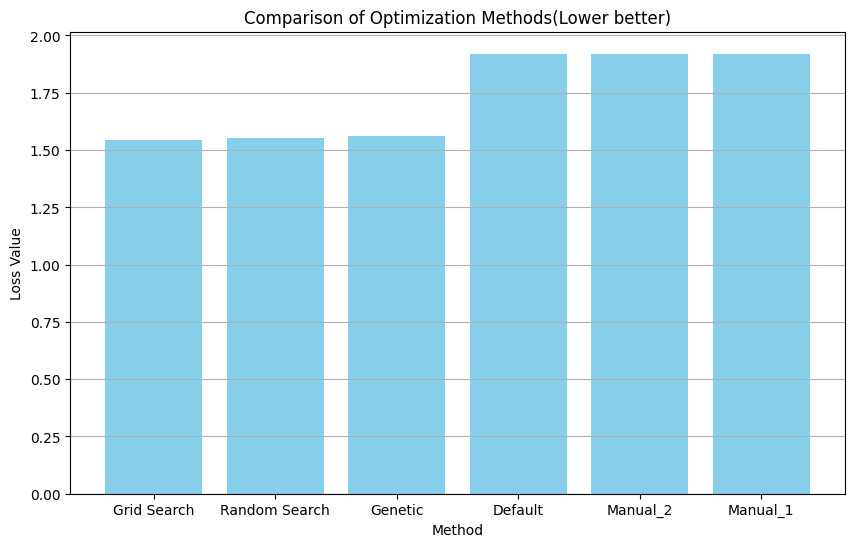

In [396]:
df_vis = pd.DataFrame(loss_dict.items(), columns=['Method', 'Loss Value'])

# Sort the DataFrame by 'Loss Value' in ascending order
df_vis = df_vis.sort_values(by='Loss Value', ascending=True)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(df_vis['Method'], df_vis['Loss Value'], color='skyblue')

# Add labels and title
plt.xlabel('Method')
plt.ylabel('Loss Value')
plt.title('Comparison of Optimization Methods(Lower better)')
plt.grid(axis='y')

# Save the plot
plt.show()